<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize

import gdown
%matplotlib inline

In [8]:
# Download some attributes

!gdown --id 1utdTz3TY2LyqoRHzZJVVeiku44pacQ0Y

/home/dmitry/.miniconda3/envs/dls/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
^C
Traceback (most recent call last):
  File "/home/dmitry/.miniconda3/envs/dls/bin/gdown", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/home/dmitry/.miniconda3/envs/dls/lib/python3.12/site-packages/gdown/__main__.py", line 172, in main
    download(
  File "/home/dmitry/.miniconda3/envs/dls/lib/python3.12/site-packages/gdown/download.py", line 202, in download
    res = sess.get(url, stream=True, verify=verify)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dmitry/.miniconda3/envs/dls/lib/python3.12/site-packages/requests/sessions.py", line 602, in get
    return self.request("GET", url, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dmitry/.miniconda3/envs/dls/lib/python3.12/sit

In [2]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [3]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [4]:
from sklearn.model_selection import train_test_split

train_photos, val_photos = train_test_split(data, train_size=.9)

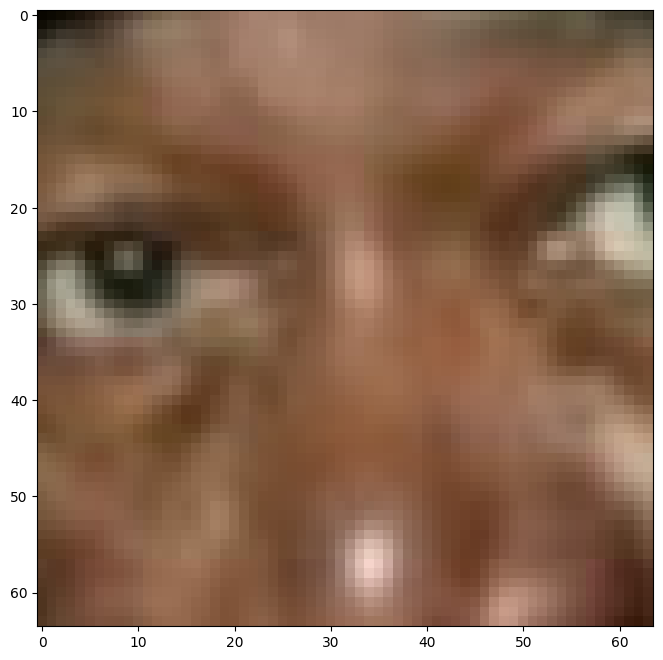

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.imshow(train_photos[0])
plt.show()

In [6]:
train_photos[0].shape

(64, 64, 3)

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.

напомню, что автоэнкодер выглядит вот так:

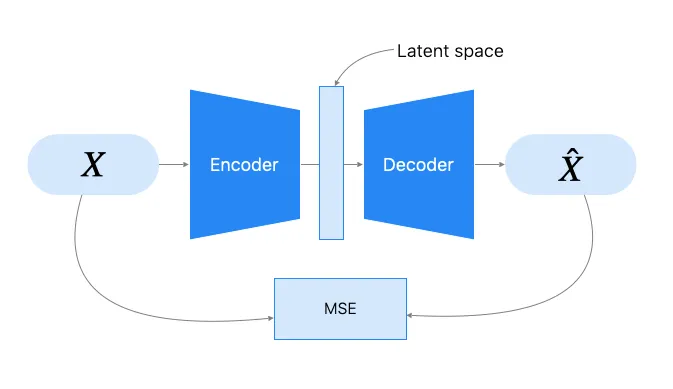

In [11]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [12]:
dim_code = 64 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [6]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=12288, out_features=512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(in_features=512, out_features=dim_code),
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=dim_code, out_features=512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(in_features=512, out_features=12288),
        )

    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        reconstruction = torch.sigmoid(reconstruction)
        reconstruction = reconstruction.view(-1, 64, 64, 3)
        
        return reconstruction, latent_code

    def sample(self, x):
        reconstruction = self.decoder(x)
        reconstruction = torch.sigmoid(reconstruction)
        reconstruction = reconstruction.view(-1, 64, 64, 3)

        return reconstruction

In [3]:
criterion = nn.MSELoss()

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

NameError: name 'Autoencoder' is not defined

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [7]:
from tqdm.notebook import tqdm

train_loader = torch.utils.data.DataLoader(train_photos, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size=32)

In [12]:
n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        optimizer.zero_grad()
        reconstruction, _ = autoencoder(batch.to(device).float())
        loss = criterion(reconstruction, batch.to(device).float())
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()

    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in val_loader:
            reconstruction, _ = autoencoder(batch.to(device).float())
            loss = criterion(reconstruction, batch.to(device).float())
            val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

  0%|          | 0/50 [00:00<?, ?it/s]

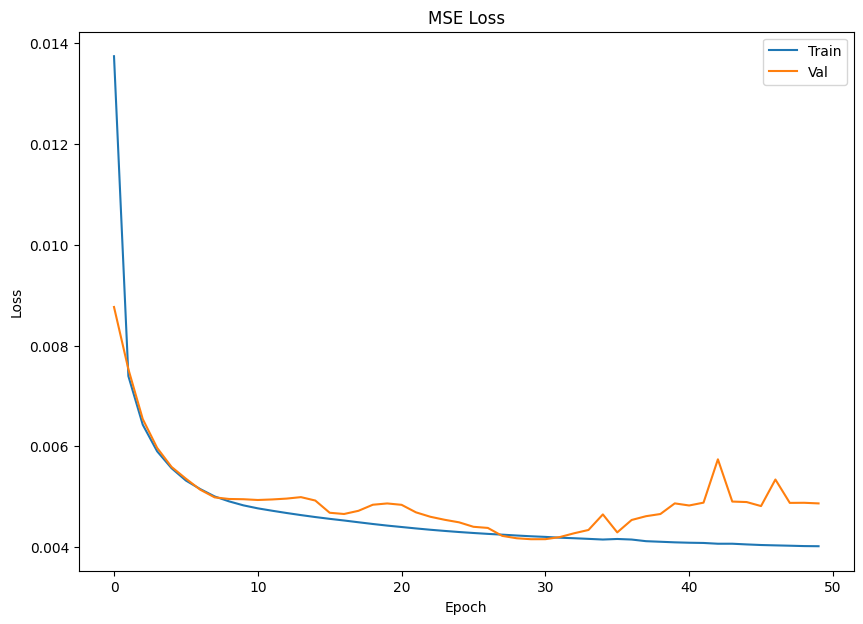

In [13]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Val')
plt.title('MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
min(val_losses)

np.float64(0.004152926139622217)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
autoencoder.eval()
with torch.no_grad():
    for batch in val_loader:
        reconstruction, _ = autoencoder(batch.to(device).float())
        result = reconstruction.cpu().detach().numpy()
        ground_truth = batch.numpy()
        break

In [ ]:
plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(gt)
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(res)

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

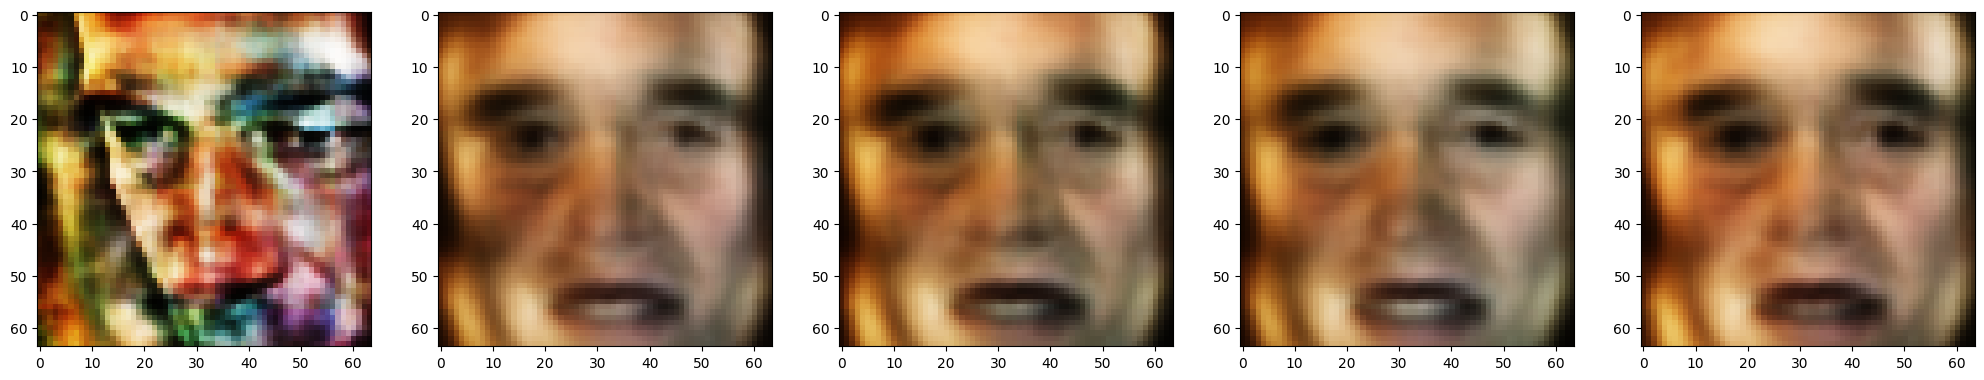

In [72]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(5, dim_code)

output = autoencoder.sample(torch.FloatTensor(z).to(device))
output = output.cpu().detach().numpy()
plt.figure(figsize=(25, 25))
for i, res in enumerate(output, 1):
    plt.subplot(1, len(output), i)
    plt.imshow(res)

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [73]:
attrs.head()

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.19558,-0.835609,-0.351468,-1.012533,-0.719593,...,0.361738,1.166118,-1.164916,-1.13999,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.282184,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.66676,-0.496559
2,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,-1.341523,-0.090037,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231
3,1.122719,-1.997799,1.916144,-2.514214,-2.580071,-1.404239,0.057551,0.000196,-1.273512,-1.431462,...,0.567822,-0.176089,1.108125,-1.600944,-3.264613,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.078214,-2.008098,1.676211,-2.278056,-2.651845,-1.348408,0.649089,0.017656,-1.889111,-1.857213,...,-1.461474,-0.955283,0.119113,-1.128176,-3.161048,0.08268,-0.439614,-0.359859,-0.760774,-0.410152


In [74]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [75]:
attrs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13143 entries, 0 to 13142
Data columns (total 73 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Male                        13143 non-null  object
 1   Asian                       13143 non-null  object
 2   White                       13143 non-null  object
 3   Black                       13143 non-null  object
 4   Baby                        13143 non-null  object
 5   Child                       13143 non-null  object
 6   Youth                       13143 non-null  object
 7   Middle Aged                 13143 non-null  object
 8   Senior                      13143 non-null  object
 9   Black Hair                  13143 non-null  object
 10  Blond Hair                  13143 non-null  object
 11  Brown Hair                  13143 non-null  object
 12  Bald                        13143 non-null  object
 13  No Eyewear                  13143 non-null  ob

In [76]:
attrs['Smiling'] = pd.to_numeric(attrs['Smiling'])

In [77]:
smile_img_indexes = attrs.nlargest(150, 'Smiling').index.tolist()

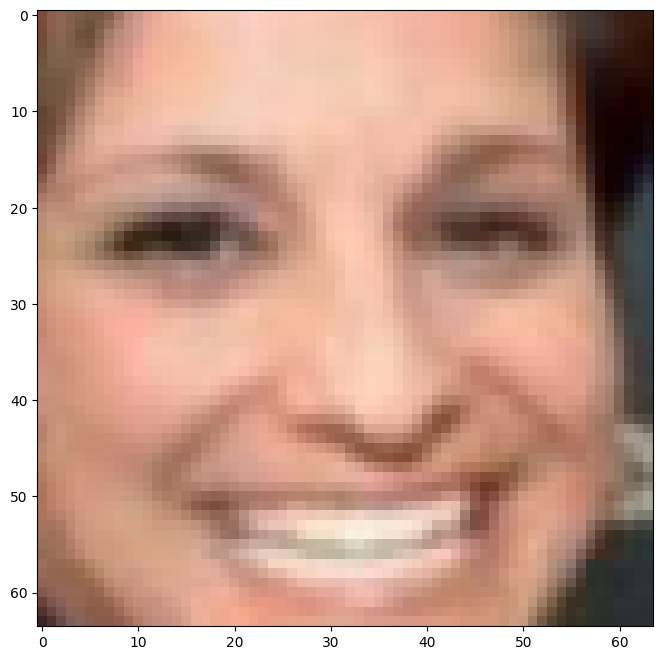

In [78]:
plt.figure(figsize=(8, 8))
plt.imshow(data[smile_img_indexes[0]])
plt.show()

In [79]:
no_smile_img_indexes = attrs.nsmallest(150, 'Smiling').index.tolist()

In [80]:
examle_index = 6

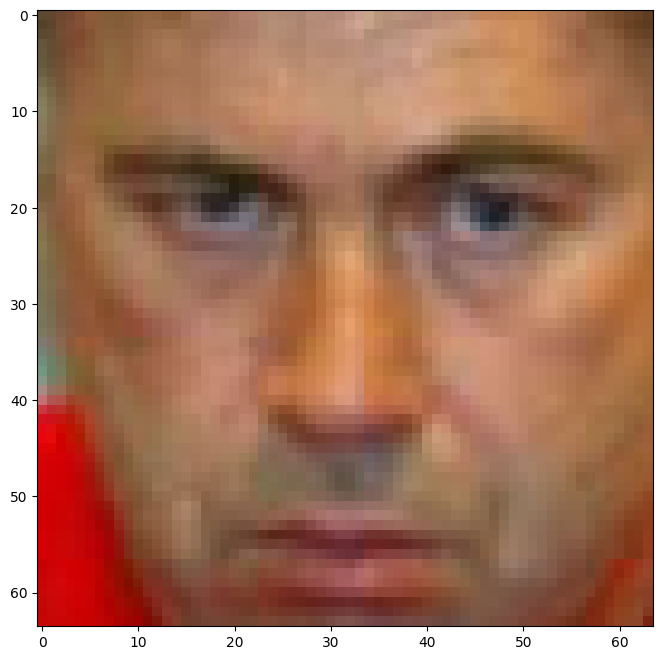

In [81]:
plt.figure(figsize=(8, 8))
plt.imshow(data[no_smile_img_indexes[examle_index]])
plt.show()

In [82]:
smile_latents = autoencoder.encoder(torch.FloatTensor(data[smile_img_indexes]).to(device))
smile_latents = smile_latents.cpu().detach().numpy()

smile_latents.shape

(150, 64)

In [83]:
no_smile_latents = autoencoder.encoder(torch.FloatTensor(data[no_smile_img_indexes]).to(device))
no_smile_latents = no_smile_latents.cpu().detach().numpy()

no_smile_latents.shape

(150, 64)

In [84]:
diff_lattents = np.mean(smile_latents, axis=0) - np.mean(no_smile_latents, axis=0)
diff_lattents

array([-1.2346121 , -1.0612435 ,  2.8573947 , -1.5653999 ,  0.11866128,
       -1.0941336 ,  1.3809326 , -1.2920418 ,  1.1395639 ,  0.35752797,
       -1.2890013 , -3.1202917 ,  0.39492178, -3.5290785 , -1.0558634 ,
        1.5287507 ,  0.7289032 , -0.41465592, -1.2268362 , -4.182918  ,
        0.5853098 ,  1.3065355 ,  0.35665047, -1.3981115 ,  0.0531888 ,
       -0.2674422 ,  0.14949794, -0.23292756,  1.3165989 ,  1.3936286 ,
       -1.9699752 , -1.8058012 , -0.6453035 , -0.8092739 , -1.4198749 ,
       -1.4918518 ,  1.8026143 ,  0.63209075, -2.881887  ,  0.15869606,
        1.639868  , -0.1957525 ,  1.5203742 ,  0.70846546, -3.3583167 ,
        1.9369836 ,  1.5098143 , -0.05341244,  2.235374  , -1.5570221 ,
        2.5066726 , -0.5938815 ,  0.468022  ,  0.4756968 , -0.14941931,
        1.4525198 , -0.06952077, -2.6422346 ,  0.02834648,  0.3880407 ,
        0.07131553,  0.36423823,  0.40444565,  1.8740206 ], dtype=float32)

In [85]:
no_smile_latent = autoencoder.encoder(torch.FloatTensor([data[no_smile_img_indexes[examle_index]]]).to(device))
no_smile_latent = no_smile_latent.cpu().detach().numpy().squeeze()
no_smile_latent

array([ 3.81569341e-02,  1.00233345e+01,  1.47421956e+00, -3.18405724e+00,
       -2.87615871e+00, -3.63869369e-01,  4.45429504e-01,  2.19258213e+00,
       -5.52026176e+00, -2.92006660e+00, -2.33092451e+00,  1.41449571e-01,
        2.23043370e+00, -9.59533930e-01,  5.78935242e+00, -2.13594928e-01,
       -2.18565583e+00,  2.88229036e+00,  1.64645123e+00,  2.58229160e+00,
       -9.40617085e-01,  3.59286976e+00,  3.46748018e+00,  2.53821778e+00,
        3.22738552e+00,  1.16398096e+00, -4.44686204e-01,  7.33145893e-01,
       -2.80392838e+00, -6.25880527e+00, -7.06657469e-01,  3.50370407e-01,
        3.90444851e+00,  1.85162354e+00, -6.18912816e-01, -1.65013528e+00,
       -1.47919607e+00, -1.89763308e+00, -4.91911083e-01, -1.23365104e+00,
        2.44029713e+00,  3.99847150e-01, -7.82368898e-01, -3.83946443e+00,
        1.25426143e-01,  1.77559614e+00,  2.66942430e+00, -7.88514996e+00,
       -3.43463826e+00,  1.00042057e+00, -2.70419210e-01, -3.85115290e+00,
       -5.12674376e-02, -

In [86]:
new_latent = no_smile_latent + diff_lattents
reconstruction = autoencoder.sample(torch.FloatTensor([new_latent]).to(device))
reconstruction = reconstruction.cpu().detach().numpy().squeeze()

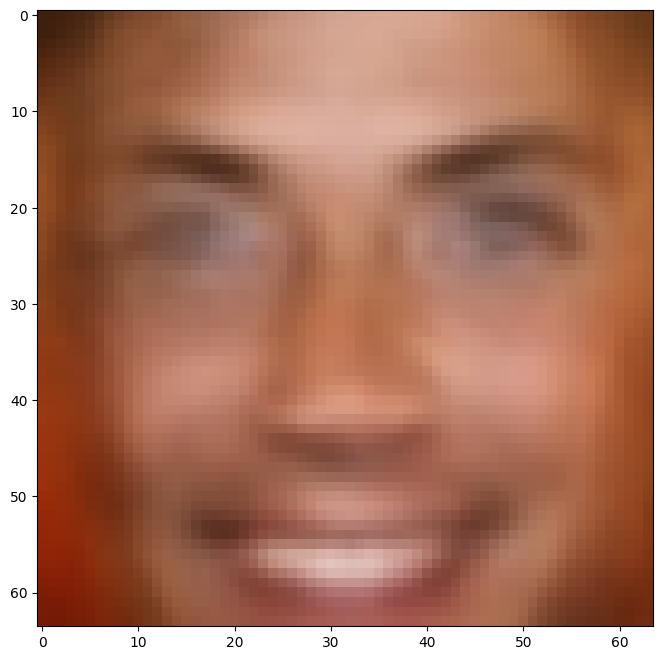

In [87]:
plt.figure(figsize=(8, 8))
plt.imshow(reconstruction)
plt.show()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [88]:
features = 64

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=12288, out_features=512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(in_features=512, out_features=features*2),
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=features, out_features=512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(in_features=512, out_features=12288)
        )

    def encode(self, x):
        x = self.encoder(x).view(-1, 2, features)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]

        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)

            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)

        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        sample = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(sample)

        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [8]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [90]:
criterion = loss_vae

autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

In [91]:
n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        data = batch
        optimizer.zero_grad()
        mu, logsigma, reconstruction = autoencoder(data.to(device).float())
        reconstruction = reconstruction.view(-1, 64, 64, 3)
        loss = criterion(data.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    val_losses_per_epoch = []
    
    autoencoder.eval()
    with torch.no_grad():
        for batch in val_loader:
            data = batch
            mu, logsigma, reconstruction = autoencoder(data.to(device).float())
            reconstruction = reconstruction.view(-1, 64, 64, 3)
            loss = criterion(data.to(device).float(), mu, logsigma, reconstruction)
            val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

  0%|          | 0/50 [00:00<?, ?it/s]

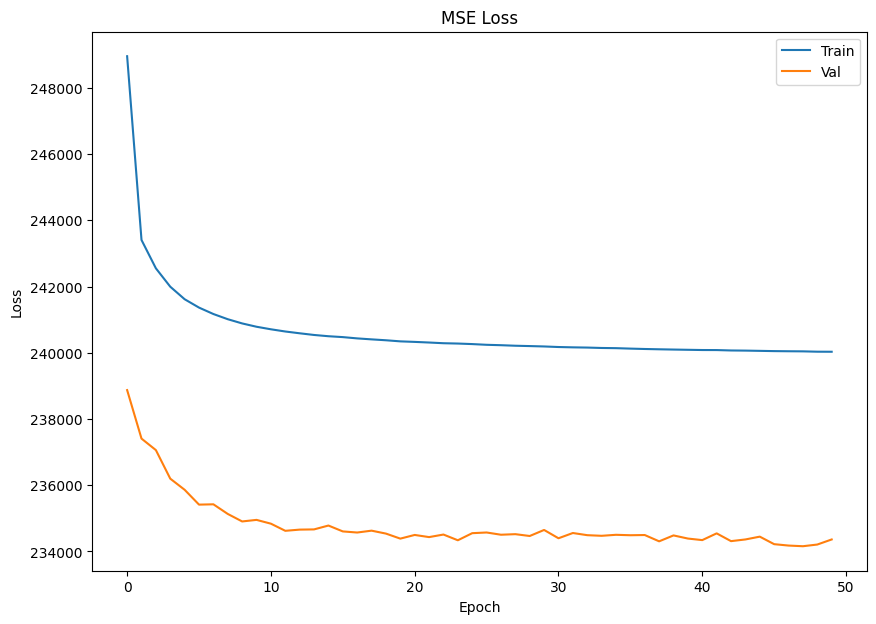

In [92]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Val')
plt.title('VAE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [93]:
min(val_losses)

np.float64(234158.56031436013)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [94]:
autoencoder.eval()
for batch in val_loader:
    data = batch
    mu, logsigma, reconstruction = autoencoder(data.to(device).float())
    reconstruction = reconstruction.view(-1, 64, 64, 3)
    result = reconstruction.cpu().detach().numpy()
    ground_truth = data.numpy()
    break

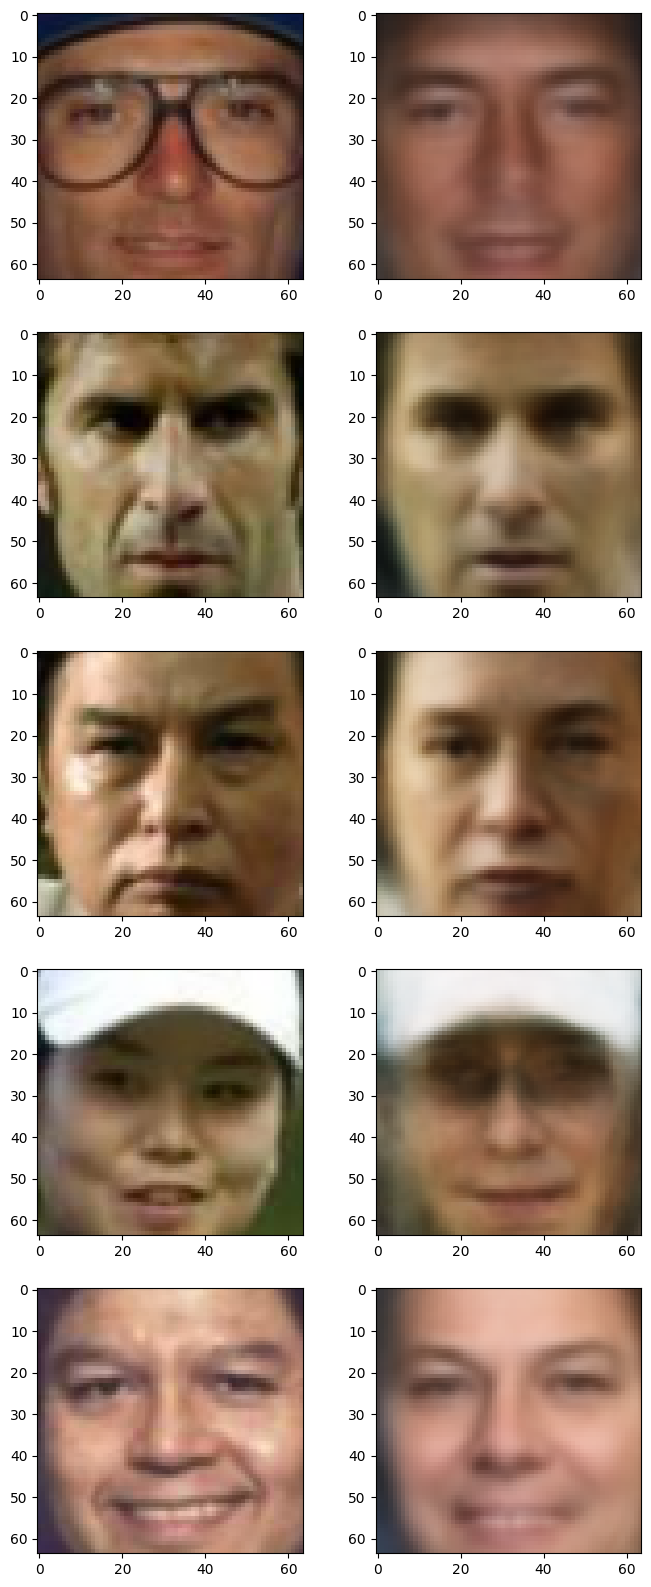

In [95]:
plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(gt)
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(res)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

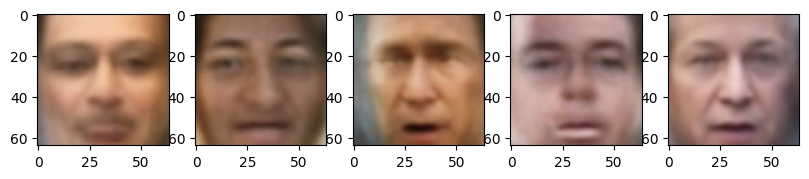

In [96]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, features) for i in range(5)])
output = autoencoder.decode(torch.FloatTensor(z).to(device))
output = output.view(-1, 64, 64, 3)
output = output.cpu().detach().numpy()

plt.figure(figsize=(20, 20))
for i, res in enumerate(output, 1):
    plt.subplot(1, 10, i)
    plt.imshow(res)

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [97]:
no_smile_latents.shape

(150, 64)

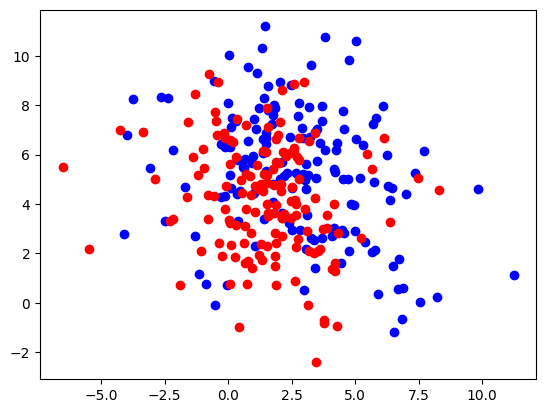

In [98]:
plt.scatter(no_smile_latents[:, 0], no_smile_latents[:, 1], color='blue')
plt.scatter(smile_latents[:, 0], smile_latents[:, 1], color='red')

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

In [4]:
from torchvision import transforms

batch_size = 32
# MNIST Dataset
train_dataset_cvae = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset_cvae = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader_cvae = torch.utils.data.DataLoader(dataset=train_dataset_cvae, batch_size=batch_size, shuffle=True)
val_loader_cvae = torch.utils.data.DataLoader(dataset=test_dataset_cvae, batch_size=batch_size, shuffle=False)

In [5]:
for batch in val_loader_cvae:
    print(batch[0].shape)
    break

torch.Size([32, 1, 28, 28])


### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [17]:
features = 64

class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=8624, out_features=512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(in_features=512, out_features=features*2),
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=features+10, out_features=512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(in_features=512, out_features=784)
        )

    def encode(self, x, one_hot_labels):
        one_hot_labels_view = one_hot_labels.view(-1, 10, 1, 1)
        one_hot_labels_expand = one_hot_labels_view.expand(-1, -1, 28, 28)
        
        x = torch.cat([x, one_hot_labels_expand], dim=1)
        x = self.encoder(x).view(-1, 2, features)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]

        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)

            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, one_hot_labels):
        z = torch.cat([z, one_hot_labels], dim=1)
        z = self.decoder(z)
        reconstruction = torch.sigmoid(z)

        return reconstruction

    def forward(self, x, labels):
        one_hot_labels = F.one_hot(torch.tensor(labels), num_classes=10).float()
        
        mu, logsigma = self.encode(x, one_hot_labels)
        sample = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(sample, one_hot_labels)

        return mu, logsigma, reconstruction

In [18]:
criterion_cvae = loss_vae
autoencoder_cvae = CVAE().to(device)
optimizer_cvae = torch.optim.Adam(autoencoder_cvae.parameters())

In [19]:
from tqdm.notebook import tqdm

n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder_cvae.train()
    train_losses_per_epoch = []
    for images, labels in train_loader_cvae:
        optimizer_cvae.zero_grad()
        mu, logsigma, reconstruction = autoencoder_cvae(images.to(device).float(), labels.to(device))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion_cvae(images.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer_cvae.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    val_losses_per_epoch = []
    
    autoencoder_cvae.eval()
    with torch.no_grad():
        for images, labels in val_loader_cvae:
            mu, logsigma, reconstruction = autoencoder_cvae(images.to(device).float(), labels.to(device))
            reconstruction = reconstruction.view(-1, 1, 28, 28)
            loss = criterion_cvae(images.to(device).float(), mu, logsigma, reconstruction)
            val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_27496/1719129784.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  one_hot_labels = F.one_hot(torch.tensor(labels), num_classes=10).float()


In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        <определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста",
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>

    def encode(self, x, class_num):
        <реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и класс картинки>

        return mu, logsigma, class_num

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, class_num):
        <реализуйте forward проход декодера
        в качестве возвращаемой переменной -- reconstruction>

        return reconstruction

    def forward(self, x):
        <используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        return mu, logsigma, reconstruction

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

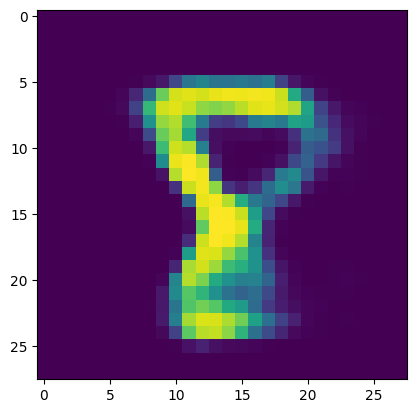

In [20]:
autoencoder_cvae.eval()

labels = np.array([8])
one_hot_labels = F.one_hot(torch.tensor(labels), num_classes=10).float()
z = np.array([np.random.normal(0, 1, features)])
output = autoencoder_cvae.decode(torch.FloatTensor(z).to(device), one_hot_labels.to(device))
output = output.view(-1, 1, 28, 28)
output = output.permute(0, 2, 3, 1)
output = output.cpu().detach().numpy()

plt.imshow(output[0])

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [30]:

class_data = {}
for images, labels in val_loader_cvae:
    one_hot_labels = F.one_hot(torch.tensor(labels), num_classes=10).float()
    mu, logsigma = autoencoder_cvae.encode(torch.FloatTensor(images).to(device), one_hot_labels.to(device))
    mu = mu.cpu().detach().numpy()
    logsigma = logsigma.cpu().detach().numpy()
 
    for i, label in enumerate(labels.cpu().detach().numpy()):
        if label not in class_data:
            class_data[label] = {
                'mu': [],
                'logsigma': []
            }
            
        class_data[label]['mu'].append(mu[i])
        class_data[label]['logsigma'].append(logsigma[i])

/tmp/ipykernel_27496/1304623819.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  one_hot_labels = F.one_hot(torch.tensor(labels), num_classes=10).float()


In [43]:
import numpy as np
from sklearn.manifold import TSNE

all_features = []
all_labels = []

for label in class_data:
    mu = np.array(class_data[label]['mu'])
    logsigma = np.array(class_data[label]['logsigma'])
    
    features = np.concatenate([mu, logsigma], axis=1)
    
    all_features.append(features)
    all_labels.extend([label] * len(features))

all_features = np.vstack(all_features)
all_labels = np.array(all_labels)

In [44]:
tsne = TSNE(n_components=1, random_state=42)
y_tsne = tsne.fit_transform(all_features).flatten()

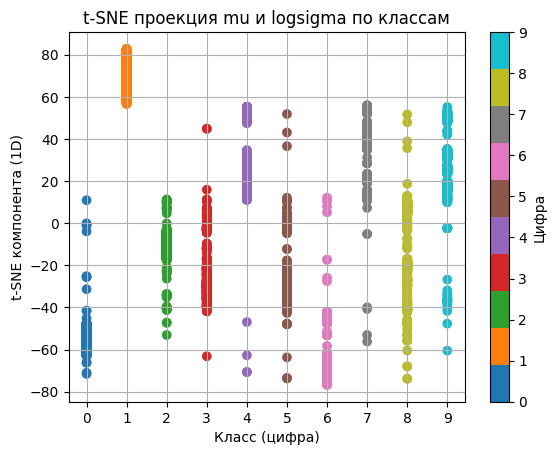

In [60]:
scatter = plt.scatter(
    x=all_labels,
    y=y_tsne,
    c=all_labels,
    cmap='tab10',
)

# Настройки графика
plt.title('t-SNE проекция mu и logsigma по классам')
plt.xlabel('Класс (цифра)')
plt.ylabel('t-SNE компонента (1D)')
plt.xticks(range(10))    # Метки 0-9 на оси X
plt.colorbar(scatter, label='Цифра')
plt.grid(True)
plt.show()

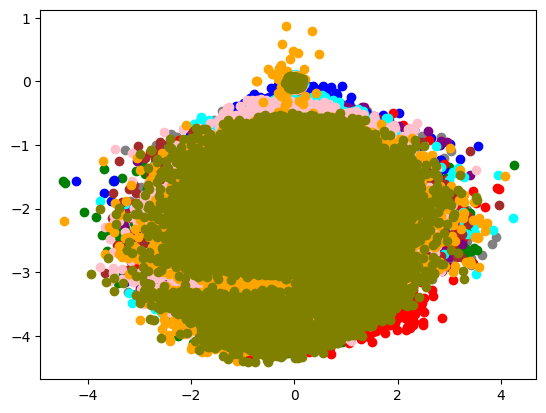

In [63]:
from sklearn.manifold import TSNE

colors = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'orange',
    4: 'purple',
    5: 'brown',
    6: 'pink',
    7: 'gray',
    8: 'olive',
    9: 'cyan'
}
for key, value in class_data.items():
    plt.scatter(value['mu'], value['logsigma'], color=colors[key])

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [9]:
def add_noize(X, noise_factor=0.5):
    return X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

In [28]:
criterion = nn.MSELoss()
autoencoder = Autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

In [29]:
n_epochs = 50

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    for batch in train_loader:
        optimizer.zero_grad()
        reconstruction, _ = autoencoder(add_noize(batch).to(device).float())
        loss = criterion(reconstruction, batch.to(device).float())
        loss.backward()
        optimizer.step()

  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_6092/3230209749.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)


In [30]:
autoencoder.eval()
for batch in val_loader:
    batch_with_noize = add_noize(batch[:5])
    reconstruction, _ = autoencoder(batch_with_noize.to(device).float())
    reconstruction = reconstruction.view(-1, 64, 64, 3)
    result = reconstruction.cpu().detach().numpy()
    ground_truth = batch_with_noize.numpy()
    break

/tmp/ipykernel_6092/3230209749.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6211090777989483..2.5693201740769744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7489309500077728..2.368772187934928].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5445252355934316..2.5636889753966052].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4181551824811256..2.513557582895629].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.603463762365546..2.403471580030291].


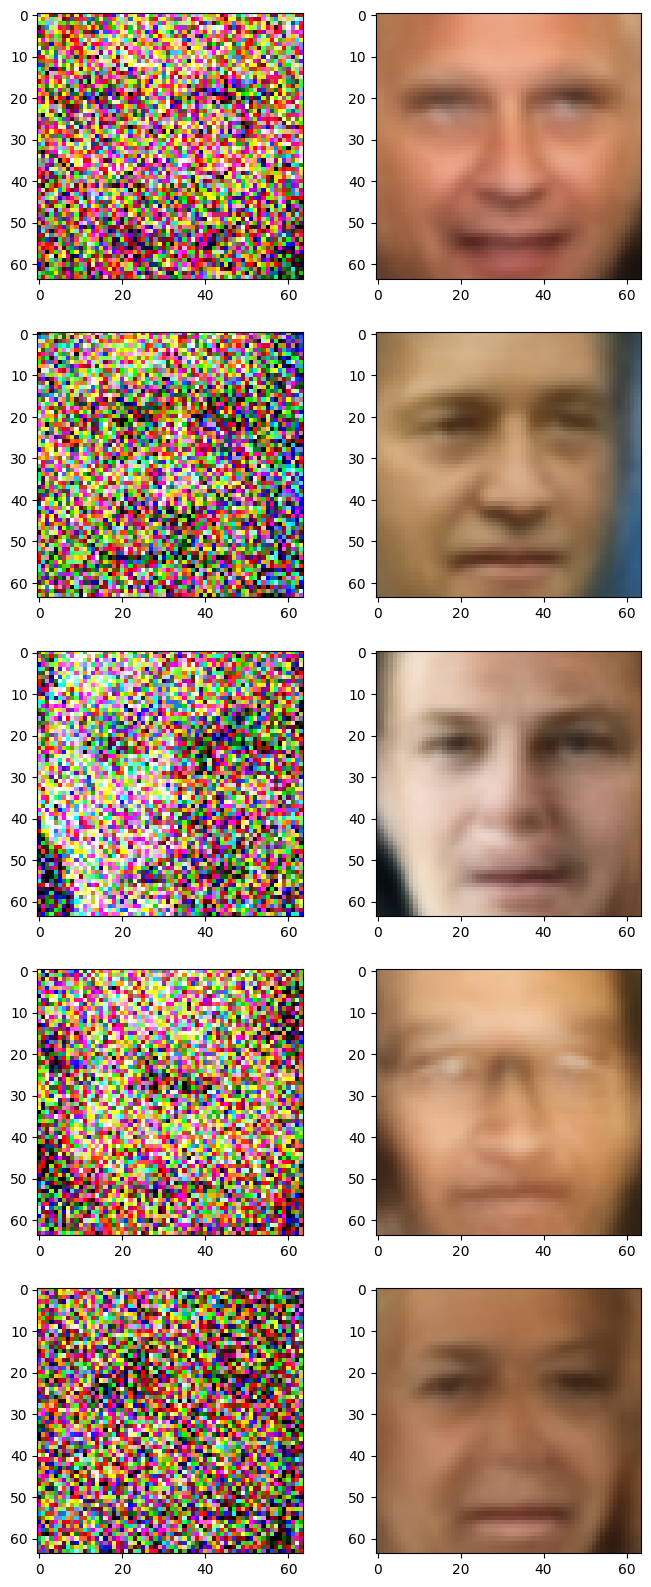

In [31]:
plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(gt)
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(res)

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [108]:
codes = []
criterion = nn.MSELoss()
autoencoder = Autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

In [109]:
n_epochs = 50

for epoch in tqdm(range(n_epochs)):
    for batch in train_loader:
        optimizer.zero_grad()
        reconstruction, latent_codes = autoencoder(batch.to(device).float())
        loss = criterion(reconstruction, batch.to(device).float())
        loss.backward()
        optimizer.step()

        if epoch == n_epochs-1:
            for latent_code in latent_codes.cpu().detach().numpy():
                codes.append(latent_code)

  0%|          | 0/50 [00:00<?, ?it/s]

In [110]:
autoencoder.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12288, out_features=512, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=512, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=512, out_features=12288, bias=True)
  )
)

In [147]:
from sklearn.neighbors import NearestNeighbors

model = NearestNeighbors(n_neighbors=11, metric='euclidean')
model.fit(codes)

NearestNeighbors(metric='euclidean', n_neighbors=11)

In [148]:
def get_similar(image):
    # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
    # прогоняет векторы через декодер и получает картинки ближайших людей
    codes = autoencoder.encoder(image.to(device).float())
    codes = codes.cpu().detach().numpy()

    distances, idx = model.kneighbors(codes)

    return distances[0], train_photos[idx][0]

In [155]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    distances, neighbors = get_similar(torch.tensor([image]))

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image)
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

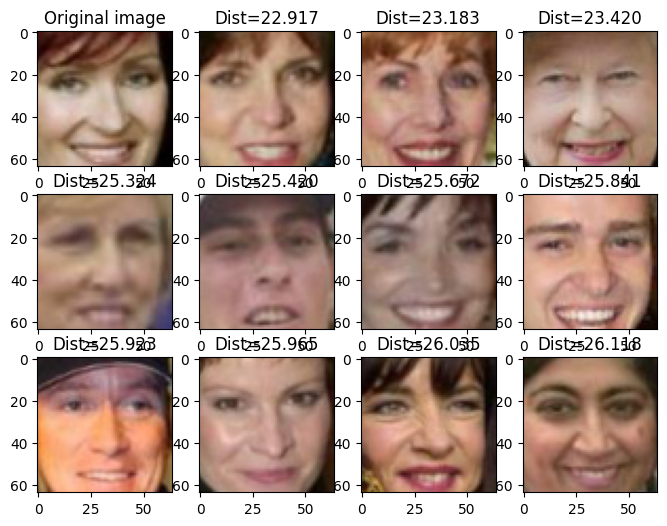

In [160]:
show_similar(val_photos[15])